---
# Modelling
---

Import libraries and load data

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
DATA_PATH="../data/raw/aclImdb_v1/aclImdb/train/"
PROCESSED_DATA_PATH="../data/processed/"
RANDOM_SEED=42

In [2]:
# Initialisez la session Spark
spark = SparkSession.builder \
    .appName(" traitement BoW puis Tf-IDF avec PySpark") \
    .getOrCreate()

# BOW

In [4]:
bow_df=pd.read_csv(PROCESSED_DATA_PATH+"bow_df.csv")

In [50]:
bow = spark.createDataFrame(bow_df)
bow.show(5)

+----------+--------------------+--------------------+-----+
|Unnamed: 0|        tokens_array|            features|Label|
+----------+--------------------+--------------------+-----+
|         0|['panic', 'street...|(87968,[0,2,3,4,5...|    1|
|         1|['ask', 'well', '...|(87968,[1,4,8,9,1...|    0|
|         2|['big', 'fan', 'f...|(87968,[1,3,4,5,7...|    1|
|         3|['finish', 'read'...|(87968,[1,3,5,10,...|    0|
|         4|['greg', 'davis',...|(87968,[2,5,15,68...|    0|
+----------+--------------------+--------------------+-----+
only showing top 5 rows



## Regression Logistique

In [34]:
train_data, test_data = bow.randomSplit([0.7, 0.3], seed=RANDOM_SEED)
lr = LogisticRegression(featuresCol="features", labelCol="Label")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)


# Évaluer les performances du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print("Precision:", precision)

recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
print("Recall:", recall)

f1 = evaluator.setMetricName("f1").evaluate(predictions)
print("F1 Score:", f1)

Accuracy: 0.8372124863088719
Precision: 0.837452397775956
Recall: 0.8372124863088719
F1 Score: 0.8371907427702736


AUC: 0.8372468809336789


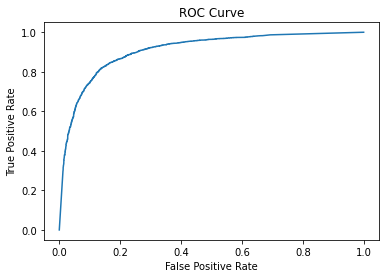

In [35]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="prediction")

auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
print("AUC:", auc)

roc = predictions.select("Label", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["Label"]))).collect()
roc_df = pd.DataFrame(roc, columns=["score", "label"])
fpr, tpr, thresholds = roc_curve(roc_df["label"], roc_df["score"])

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

## svm

In [12]:
svm = LinearSVC(featuresCol="features", labelCol="Label")
svm_model = svm.fit(train_data)
predictions = svm_model.transform(test_data)

# Évaluer les performances du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print("Precision:", precision)

recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
print("Recall:", recall)

f1 = evaluator.setMetricName("f1").evaluate(predictions)
print("F1 Score:", f1)

Accuracy: 0.8681544359255202
Precision: 0.8683345850433632
Recall: 0.8681544359255202
F1 Score: 0.8681429159532089


AUC: 0.9347369544164494


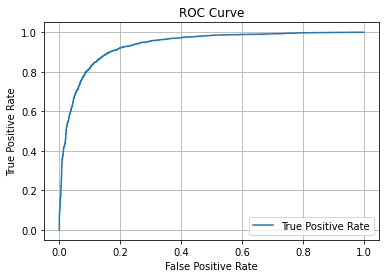

In [13]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="rawPrediction")

# AUC
auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
print("AUC:", auc)

# Pour obtenir les points de la courbe ROC, nous devons extraire les scores de décision et les labels
roc = predictions.select("Label", "rawPrediction").rdd.map(lambda row: (float(row["rawPrediction"][1]), float(row["Label"]))).collect()
roc_df = pd.DataFrame(roc, columns=["score", "label"])

# Calcul des points de la courbe ROC
fpr, tpr, thresholds = roc_curve(roc_df["label"], roc_df["score"])

# Tracer la courbe ROC avec pandas et matplotlib
roc_points_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Thresholds': thresholds})

# Tracer la courbe ROC
roc_points_df.plot(x='False Positive Rate', y='True Positive Rate', kind='line', title='ROC Curve', grid=True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Naive Bayes

In [15]:
nb = NaiveBayes(featuresCol="features", labelCol="Label")
nb_model = nb.fit(train_data)
predictions = nb_model.transform(test_data)


# Évaluer les performances du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print("Precision:", precision)

recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
print("Recall:", recall)

f1 = evaluator.setMetricName("f1").evaluate(predictions)
print("F1 Score:", f1)

Accuracy: 0.8556955093099672
Precision: 0.8566608376067925
Recall: 0.8556955093099672
F1 Score: 0.8555853144245562


AUC: 0.8556224471403023


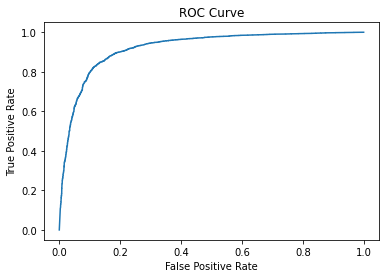

In [18]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="prediction")

auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
print("AUC:", auc)

roc = predictions.select("Label", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["Label"]))).collect()
roc_df = pd.DataFrame(roc, columns=["score", "label"])

fpr, tpr, thresholds = roc_curve(roc_df["label"], roc_df["score"])

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# TF IDF

In [43]:
TFIDF_df=pd.read_csv(PROCESSED_DATA_PATH+"TFIDF_df.csv")

In [49]:
TFIDF=spark.createDataFrame(TFIDF_df)
TFIDF.show(5)

+----------+--------------------+--------------------+-----+
|Unnamed: 0|        tokens_array|            features|Label|
+----------+--------------------+--------------------+-----+
|         0|['panic', 'street...|(262144,[1603,188...|    1|
|         1|['ask', 'well', '...|(262144,[4757,636...|    0|
|         2|['big', 'fan', 'f...|(262144,[5451,799...|    1|
|         3|['finish', 'read'...|(262144,[2701,853...|    0|
|         4|['greg', 'davis',...|(262144,[619,1729...|    0|
+----------+--------------------+--------------------+-----+
only showing top 5 rows



## Regression Logistique

In [36]:
train_data, test_data = TFIDF.randomSplit([0.7, 0.3], seed=RANDOM_SEED)
lr = LogisticRegression(featuresCol="features", labelCol="Label")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

# metrics
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print("Precision:", precision)

recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
print("Recall:", recall)

f1 = evaluator.setMetricName("f1").evaluate(predictions)
print("F1 Score:", f1)


Accuracy: 0.8396768893756845
Precision: 0.839821429576788
Recall: 0.8396768893756845
F1 Score: 0.83966526161194


AUC: 0.8397030547490276


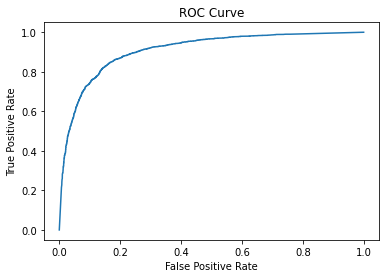

In [37]:
# Utilisation de BinaryClassificationEvaluator pour AUC et ROC
binary_evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="prediction")

auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
print("AUC:", auc)

roc = predictions.select("Label", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["Label"]))).collect()
roc_df = pd.DataFrame(roc, columns=["score", "label"])
fpr, tpr, thresholds = roc_curve(roc_df["label"], roc_df["score"])

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# SVM

In [38]:
svm = LinearSVC(featuresCol="features", labelCol="Label")
svm_model = svm.fit(train_data)
predictions = svm_model.transform(test_data)

# Évaluer les performances du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print("Precision:", precision)

recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
print("Recall:", recall)

f1 = evaluator.setMetricName("f1").evaluate(predictions)
print("F1 Score:", f1)

Accuracy: 0.8629518072289156
Precision: 0.8630115445058051
Recall: 0.8629518072289157
F1 Score: 0.8629489171520449


AUC: 0.9302849800449942


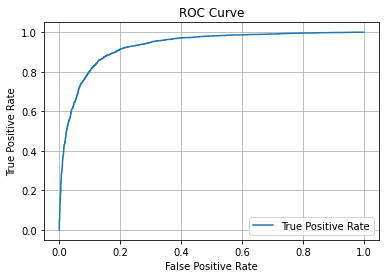

In [40]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="rawPrediction")

auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
print("AUC:", auc)

roc = predictions.select("Label", "rawPrediction").rdd.map(lambda row: (float(row["rawPrediction"][1]), float(row["Label"]))).collect()
roc_df = pd.DataFrame(roc, columns=["score", "label"])

fpr, tpr, thresholds = roc_curve(roc_df["label"], roc_df["score"])
roc_points_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Thresholds': thresholds})
roc_points_df.plot(x='False Positive Rate', y='True Positive Rate', kind='line', title='ROC Curve', grid=True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## NaiveBayes

In [41]:
nb = NaiveBayes(featuresCol="features", labelCol="Label")
nb_model = nb.fit(train_data)
predictions = nb_model.transform(test_data)

# Évaluer les performances du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print("Precision:", precision)

recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
print("Recall:", recall)

f1 = evaluator.setMetricName("f1").evaluate(predictions)
print("F1 Score:", f1)

Accuracy: 0.8248904709748083
Precision: 0.8259511790261185
Recall: 0.8248904709748084
F1 Score: 0.824730324530561


AUC: 0.8248100547919157


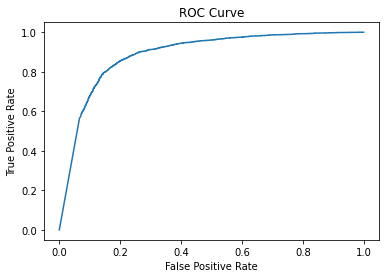

In [42]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="prediction")
auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
print("AUC:", auc)

roc = predictions.select("Label", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["Label"]))).collect()
roc_df = pd.DataFrame(roc, columns=["score", "label"])

fpr, tpr, thresholds = roc_curve(roc_df["label"], roc_df["score"])

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()